# Apache Airflow для аналитика

# 3.4 Подробнее про код: xcom, контекст: Проектная работа #2

In [ ]:
from airflow import DAG
from datetime import timedelta
from airflow.utils.dates import days_ago
from airflow.operators.dummy_operator import DummyOperator

dag = DAG('dag',schedule_interval=timedelta(days=1), start_date=days_ago(1))
t1 = DummyOperator(task_id='task_1', dag=dag)
t2 = DummyOperator(task_id='task_2',dag=dag)
t3 = DummyOperator(task_id='task_3',dag=dag)
t4 = DummyOperator(task_id='task_4',dag=dag)
t5 = DummyOperator(task_id='task_5',dag=dag)
t6 = DummyOperator(task_id='task_6',dag=dag)
t7 = DummyOperator(task_id='task_7',dag=dag)

[t1, t2]>>t5
t3>>t6
[t5,t6] >>  t7
t4

На прошлом шаге мы написали простой пайплайн и обернули его в Airflow. Теперь давайте расширим его возможности с помощью макросов и Xcom. Во всех задачах вам необходимо использовать макрос {{ ds }} или аналог {{ execution_date }} чтобы данные выгружались за определенный день. Для DAG вам нужно указать даты начала и конца исполнения задач с 2021-01-01 по 2021-01-04. То есть скрипт отработает за каждый из 4 дней, и учтет контекст исполнения.


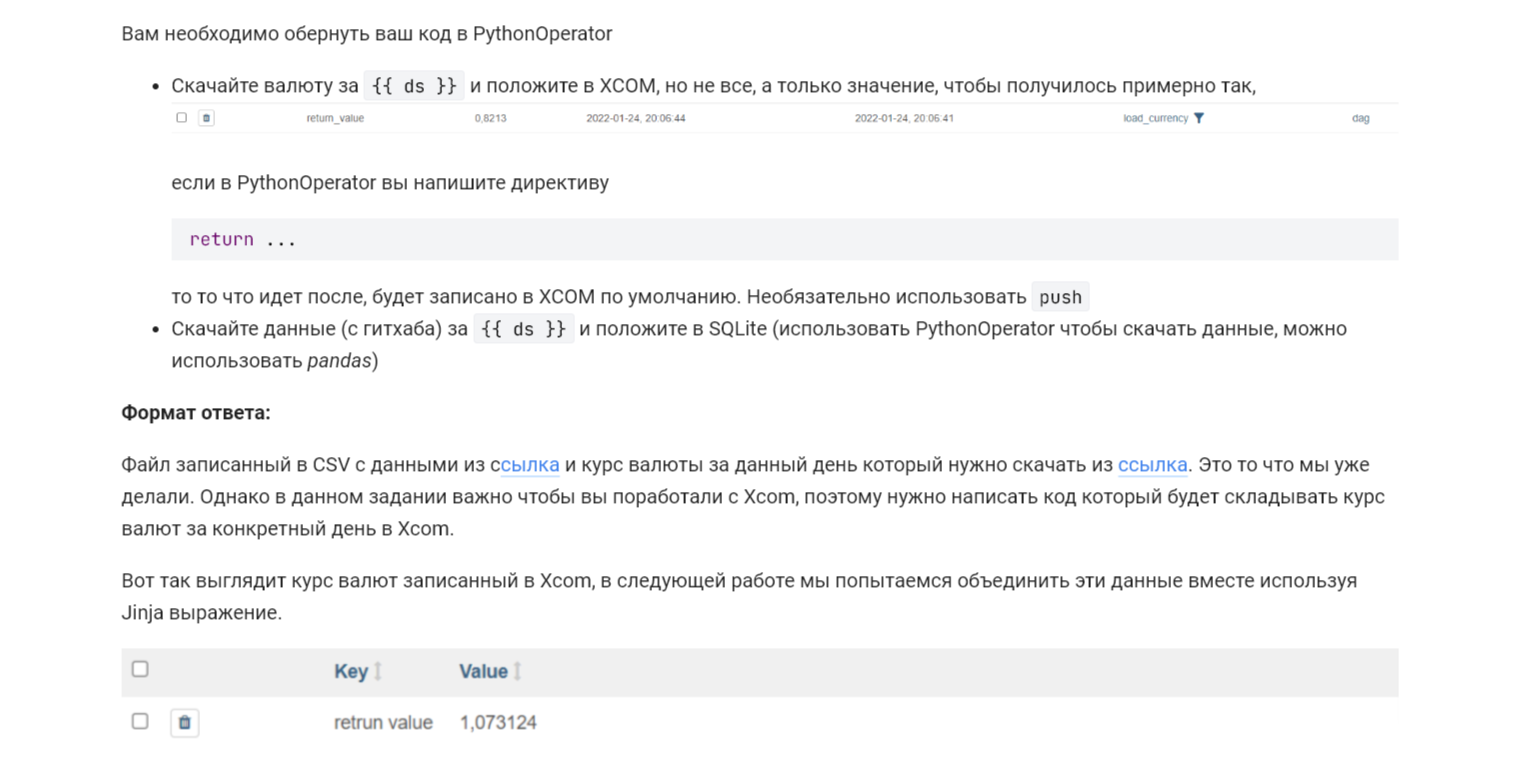

In [ ]:
# необходимые импорты
from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python_operator import PythonOperator
import sqlite3

# БД, с которой будем работать
CON = sqlite3.connect('sqlite3.db')

# функции, которые будем использовать
def extract_data(url, tmp_file, **context):
    pd.read_csv(url).to_csv(tmp_file) # изменение to_csv, запишем данные в файл
    
def transform_data(group, agreg, tmp_file, tmp_agg_file, **context):
    data = pd.read_csv(tmp_file) # изменение read_csv
    data.groupby(group).agg(agreg).reset_index().to_csv(tmp_agg_file) # изменение to_csv, запишем данные в файл
    
def merge_data(data1, data2, tmp_file):
    result=data1.merge(data2, on='date')
    pd.read_csv(result).to_csv(tmp_file)

def load_data(tmp_file, table_name, conn=CON, **context):
    data = pd.read_csv(tmp_file)# изменение read_csv, прочитаем данные из файла
    data["insert_time"] = pd.to_datetime("now")
    data.to_sql(table_name, conn, if_exists='replace', index=False)
    
    
# Создаем DAG, в который поместим наши задачи
# Для DAG-а нужно задать следующие обязательные атрибуты:
# - уникальное имя
# - интервал запусков
# - начальная точка запуска

dag = DAG(dag_id='dag', # уникальное имя дага
         default_args={'owner': 'airflow'}, # список необязательных аргументов
         schedule_interval='@daily', # интервал запусков, в данном случае 1 раз в день 24:00
         start_date=days_ago(1) # начальная точка запуска, это с какого момента мы бы хотели, чтобы скрипт начал исполняться
    )

# задача для скачивания курса валюты за 2021-01-01
extract_excangerate = PythonOperator(
    task_id='extract_excangerate', # имя задачи внутри Dag
    dag=dag,
    python_callable=extract_data, # запускаемая Python функция, описана выше
    # аргументы функции
    op_kwargs={
        'url': 'https://raw.githubusercontent.com/datanlnja/airflow_course/main/excangerate/2021-01-01.csv',
        'tmp_file': '/tmp/file1.csv'}
    )

# задача для скачивания логов финансовых транзакций за 2021-01-01
extract_data = PythonOperator(
    task_id='extract_data',
    dag=dag,
    python_callable=extract_data, 
    op_kwargs={
        'url': 'https://raw.githubusercontent.com/datanlnja/airflow_course/main/data/2021-01-01.csv',
        'tmp_file': '/tmp/file2.csv'}
    )

# задача объединения данных по дате
merge_data = PythonOperator(
    task_id='merge_data',
    dag=dag,
    python_callable = merge_data,
    op_kwargs={
        'data1':'/tmp/file1.csv',
        'data2':'/tmp/file2.csv',
        'tmp_file': '/tmp/file_merged.csv'}
    )

# задача загрузки данных в БД
load_data = PythonOperator(
    task_id='load_data',
    dag=dag,
    python_callable=load_data,
    op_kwargs={
        'tmp_file': '/tmp/file_merged.csv',
        'table_name': 'table'}
    )

# порядок выполнения задач
extract_excangerate >> extract_data >> merge_data >> load_data 

In [ ]:
# чтобы проверить решение можете обратиться к вашей базе данных таким образом

import sqlite3

# Создаем подключение к базе данных
conn = sqlite3.connect('/root/airflow/airflow.db')

# Создаем курсор для выполнения SQL-запросов
cursor = conn.cursor()

# Выполняем запрос к таблице
cursor.execute("select * from data")

# Извлекаем все строки из результата запроса
rows = cursor.fetchall()

# Выводим результаты
for row in rows:
    print(row)
    
# Закрываем соединение
conn.close()

Google Collab: https://colab.research.google.com/drive/1XYljxY1An7vw72y1g9Ujl34f7RQsWkr0?usp=sharing

Ссылка на файлы: https://github.com/dm-novikov/stepik_airflow_course/tree/main/data_new

Ссылка на Stepic: https://stepik.org/lesson/559052/step/12?unit=553147


_____________________________________________________________________________________________________________________________
Проектную работу выполнила: аналитик данных Малахова Наталья

Мой телеграм-канал: [Дневник аналитика](https://t.me/diary_musician_analyst "Дневник аналитика")

GitHub: [GitHub](https://github.com/Malakhova-Natalya "GitHub")

Habr: [Habr](https://habr.com/ru/users/Malakhova-Natalya/publications/articles/ "Habr")

Спасибо за внимание!